In [4]:
# import libraries and read datasets
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

master_df = pd.read_csv('datasets/Master.csv')
teams_df = pd.read_csv('datasets/Teams.csv')
scoring_df = pd.read_csv('datasets/Scoring.csv')

In [2]:
# clear and order data


# merge the datasets
player_data = pd.merge(scoring_df, master_df[['playerID', 'birthYear', 'height', 'weight']], on='playerID', how='left')

# convert year to datetime and calculate player age
player_data['year'] = pd.to_datetime(player_data['year'], format='%Y')
player_data['age'] = player_data['year'].dt.year - player_data['birthYear']

# height and weight over time 
physique_over_time = player_data.groupby(player_data['year'].dt.year).agg({
    'height': 'mean',
    'weight': 'mean'
}).reset_index()

# scoring trends over time
yearly_stats = player_data.groupby(player_data['year'].dt.year).agg({
    'G': 'mean',
    'A': 'mean',
    'Pts': 'mean',
    'PPG': 'mean'
}).reset_index()

## Player Physique Over Time

We'll examine how the average height and weight of NHL players have changed over the years.

- **Key Questions:**
  - Have NHL players become taller or heavier over time?
  - Are there any significant periods of change in player physique?
  - How might these changes relate to changes in scoring trends?


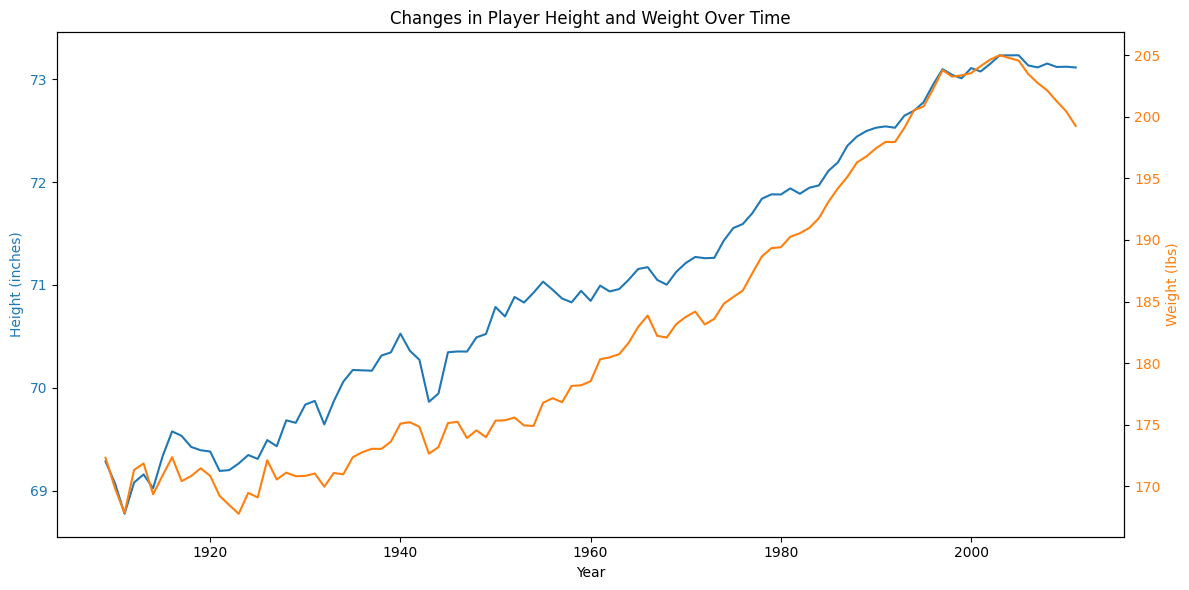

In [3]:

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Year')
ax1.set_ylabel('Height (inches)', color='tab:blue')
ax1.plot(physique_over_time['year'], physique_over_time['height'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Weight (lbs)', color='tab:orange')
ax2.plot(physique_over_time['year'], physique_over_time['weight'], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Changes in Player Height and Weight Over Time')
fig.tight_layout()
plt.show()

## Scoring Trends Over Time

We'll analyze how average goals, assists, and points per player have changed throughout NHL history.

- **Key Questions:**
  - Has scoring increased or decreased over time?
  - Are there any notable periods of high or low scoring?
  - How have the ratios of goals to assists changed?

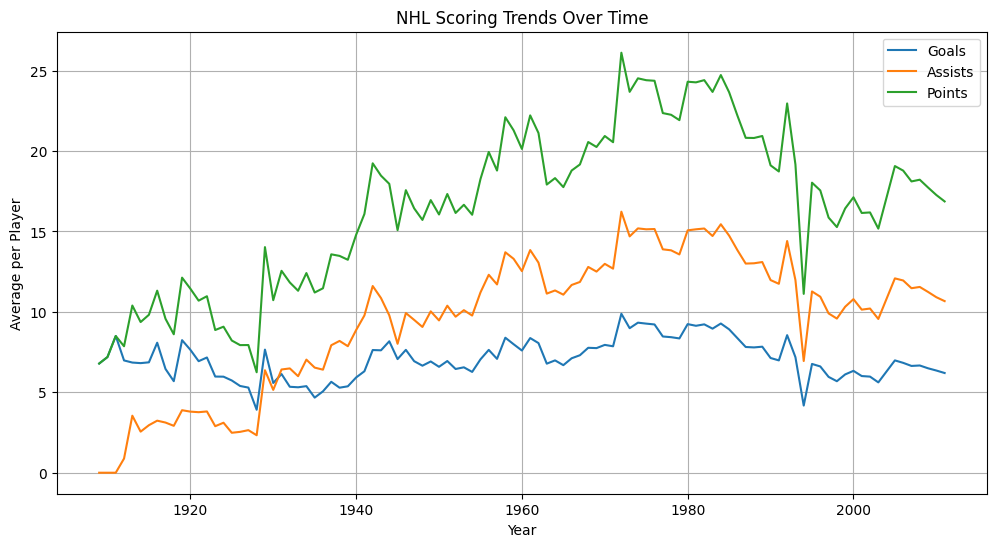

In [4]:

plt.figure(figsize=(12, 6))
# Goals
plt.plot(yearly_stats['year'], yearly_stats['G'], label='Goals')
# Assists
plt.plot(yearly_stats['year'], yearly_stats['A'], label='Assists')
# Points
plt.plot(yearly_stats['year'], yearly_stats['Pts'], label='Points')
plt.title('NHL Scoring Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average per Player')
plt.legend()
plt.grid(True)
plt.show()


### Average Penalty Minutes per Team Over Time

This graph tracks the average penalty minutes per team over the years. Trends in this metric 
can reflect changes in the physicality of the game, rule enforcement, or overall playing style. 
Significant drops might indicate rule changes aimed at reducing violent play.


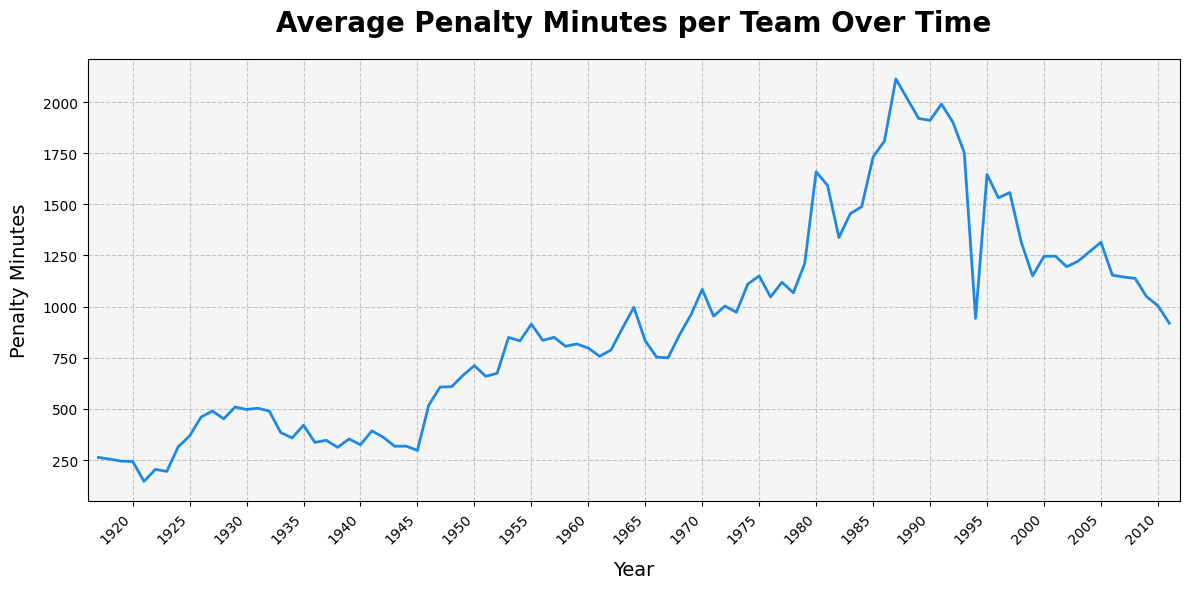

In [5]:


yearly_pim = teams_df.groupby('year')['PIM'].mean().reset_index()

plt.figure(figsize=(12, 6))

# style
plt.plot(yearly_pim['year'], yearly_pim['PIM'], color='#1E88E5', linewidth=2)

# Customize the title and labels
plt.title('Average Penalty Minutes per Team Over Time', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=10)
plt.ylabel('Penalty Minutes', fontsize=14, labelpad=10)

# x-axis
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.xticks(rotation=45, ha='right')

# y-axis
plt.gca().yaxis.set_major_locator(ticker.AutoLocator())

# gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# background color
plt.gca().set_facecolor('#F5F5F5')

# padding to the plot
plt.margins(x=0.01)

#  layout and display
plt.tight_layout()
plt.show()



### The history of rules changes in the history of the hockey league
  According to the website records.nhl.com we mapped all the changes and updates that has been done over the history of the National Hockey League.
  for that, we used several libraries and technologies:
  - BeautifulSoup: for parsing the html elements.
  - Selenium: 
    while the requested site is not written just in HTML but also JavaScript. 
    we used selenium for interacting with these dynamic elements because it actually runs a real browser.
    Selenium controls a real browser, mimicking human interactions.
    in our case, Selenium waited for the page to load and then retrieving the full page source after all dynamic content has loaded
  - webdriver_manager: 
    checking the installed version of Chrome.
    downloading the appropriate ChromeDriver if it's not already present
    then setting up the ChromeDriver.
    the Chrome WebDriver enables to automate Chrome browser actions for Selenium to use.



In [5]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time

def setup_driver():
    """
    configure the Chrome WebDriver

    Returns:
        webdriver.Chrome: Configured Chrome WebDriver instance.
    """
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Run in headless mode 
    #(without GUI)
    service = Service(ChromeDriverManager().install())
    return webdriver.Chrome(service=service, options=chrome_options)

def scrape_quotes():
    """
    scrape NHL historical rule changes from the NHL records website.

    Returns:
     DataFrame of pandas: containing years and corresponding rule changes.
    """
    url = "https://records.nhl.com/history/historical-rule-changes"
    driver = setup_driver()
    
    years = []
    rules = []

    try:
        driver.get(url)
        time.sleep(2)  # Wait for page to load
        
        page_source = driver.page_source
        soup = BeautifulSoup(page_source, 'html.parser')
        
        # get the page source and parse it with BeautifulSoup
        
        # find all 'strong' tags (which contain the years)
        raw_html = soup.find_all('strong')
        rules_changes_by_years = map(lambda x : x.parent.contents,raw_html)
        
        #iterate through the extracted elements
        for el in rules_changes_by_years:
            year = el[0].text.strip() # clean the year
            rule = el[1].strip() # clean the rule change
            years.append(year)
            rules.append(rule)

        df = pd.DataFrame({
            'Year': years,
            'Rule': rules
        })
        return df
    
    finally:
        # ensure the WebDriver is closed even if an exception occurs
        driver.quit()

df = scrape_quotes()
# df.to_csv('Rules.csv',index=False)


In [6]:
#function that prettify the text from the rule column
def break_long_string(text, max_line_length=80):
    words = text.split()
    lines = []
    current_line = []

    for word in words:
        if len(' '.join(current_line + [word])) <= max_line_length:
            current_line.append(word)
        else:
            lines.append(' '.join(current_line))
            current_line = [word]

    if current_line:
        lines.append(' '.join(current_line))

    return '\n'.join(lines)

In [11]:

# in season 1943-44 , red line rule
red_line_in_the_center = df[df['Year'].str.contains('1943-44')]['Rule'].iloc[0]
print(f"Red line rule:\n{break_long_string(red_line_in_the_center)}\n")
# in season 1956-57 , comeback for minor
comeback_for_minor = df[df['Year'].str.contains('1956-57')]['Rule'].iloc[0]
print(f"Minor penalties rule:\n{break_long_string(comeback_for_minor)}\n")
# in season 1976-77 , fight instigators penalties
fight_instigators_penalties = df[df['Year'].str.contains('1976-77')]['Rule'].iloc[0]
print(f"Penalty for fights instigator rule:\n{break_long_string(fight_instigators_penalties)}\n")

Red line rule:
Red line at center ice introduced to speed up the game and reduce offside calls.
This rule is considered to mark the beginning of the modern era in the NHL.

Minor penalties rule:
Player serving a minor penalty allowed to return to ice when a goal is scored by
opposing team.

Penalty for fights instigator rule:
Rule dealing with fighting amended to provide a major and game misconduct
penalty for any player who is clearly the instigator of a fight.

